# Casscaded RCNN

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Install 

In [ ]:
# take 40 mins
!pip install mmcv-full

     |████████████████████████████████| 416 kB 5.3 MB/s 
     |████████████████████████████████| 190 kB 50.3 MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.4.3-cp37-cp37m-linux_x86_64.whl size=58570985 sha256=fbfaafe3e9ef81e6672f6355e70db52ee3e627ba01d6de1a6ce7c70bda6c1717
  Stored in directory: /root/.cache/pip/wheels/30/85/b7/63bf15245e5bbcbf7f05013de6f39f1076ac5af44f47c9e7ba
Successfully built mmcv-full


In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
# !pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
# !pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

# Install tree
!apt-get -q install tree

Cloning into 'mmdetection'...
remote: Enumerating objects: 22714, done.
remote: Total 22714 (delta 0), reused 0 (delta 0), pack-reused 22714
Receiving objects: 100% (22714/22714), 25.63 MiB | 26.67 MiB/s, done.
Resolving deltas: 100% (15897/15897), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet
     |████████████████████████████████| 2.1 MB 5.4 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 7.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (84.8 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0+cu111 True
2.20.0
11.1
GCC 7.5


## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

In [ ]:
!mkdir checkpoints
%cd checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_x101_64x4d_fpn_20e_coco/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth
      # -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
%cd ..

/content/mmdetection/checkpoints
--2022-01-21 12:36:58--  https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_x101_64x4d_fpn_20e_coco/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 510106737 (486M) [application/octet-stream]
Saving to: ‘cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth’

cascade_rcnn_x101_6 100%[===================>] 486.48M  8.00MB/s    in 62s     

2022-01-21 12:38:02 (7.83 MB/s) - ‘cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth’ saved [510106737/510106737]

/content/mmdetection


In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'configs/cascade_rcnn/cascade_rcnn_x101_64x4d_fpn_20e_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

load checkpoint from local path: checkpoints/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth


In [ ]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


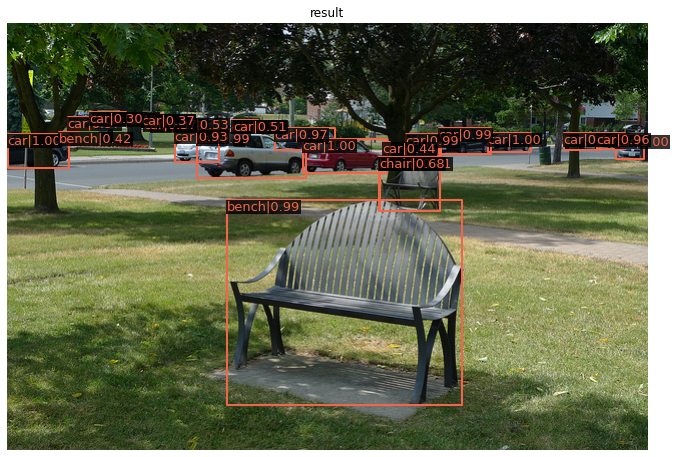

In [ ]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

Firstly, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but has 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of dataset.

In [ ]:
pwd

'/content/mmdetection'

In [ ]:
# cd ..

/content


In [ ]:
!mkdir kitti
%cd kitti
# !mkdir training
# %cd training

/content/mmdetection/kitti


In [ ]:
pwd

'/content/mmdetection/kitti'

In [ ]:
# download, decompress the data
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
!unzip data_object_image_2.zip
%rm data_object_image_2.zip
!wget  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
!unzip data_object_label_2.zip
%rm data_object_label_2.zip
# !unzip kitti_tiny.zip > /dev/null

Streaming output truncated to the last 5000 lines.
 extracting: training/label_2/001705.txt  
 extracting: training/label_2/000367.txt  
 extracting: training/label_2/006048.txt  
 extracting: training/label_2/005468.txt  
 extracting: training/label_2/007308.txt  
 extracting: training/label_2/001417.txt  
 extracting: training/label_2/006638.txt  
 extracting: training/label_2/002132.txt  
 extracting: training/label_2/002407.txt  
 extracting: training/label_2/007186.txt  
 extracting: training/label_2/004363.txt  
 extracting: training/label_2/005764.txt  
 extracting: training/label_2/003298.txt  
 extracting: training/label_2/002664.txt  
 extracting: training/label_2/002322.txt  
 extracting: training/label_2/005098.txt  
 extracting: training/label_2/007135.txt  
 extracting: training/label_2/001415.txt  
 extracting: training/label_2/000344.txt  
 extracting: training/label_2/005904.txt  
 extracting: training/label_2/007166.txt  
 extracting: training/label_2/000502.txt  
 ex

In [ ]:
%cd ..
!ls

/content/mmdetection
checkpoints   docs	   mmdet.egg-info   requirements      tests
CITATION.cff  kitti	   model-index.yml  requirements.txt  tools
configs       LICENSE	   pytest.ini	    resources
demo	      MANIFEST.in  README.md	    setup.cfg
docker	      mmdet	   README_zh-CN.md  setup.py


In [ ]:
!tree kitti

Streaming output truncated to the last 5000 lines.
        ├── 002483.txt
        ├── 002484.txt
        ├── 002485.txt
        ├── 002486.txt
        ├── 002487.txt
        ├── 002488.txt
        ├── 002489.txt
        ├── 002490.txt
        ├── 002491.txt
        ├── 002492.txt
        ├── 002493.txt
        ├── 002494.txt
        ├── 002495.txt
        ├── 002496.txt
        ├── 002497.txt
        ├── 002498.txt
        ├── 002499.txt
        ├── 002500.txt
        ├── 002501.txt
        ├── 002502.txt
        ├── 002503.txt
        ├── 002504.txt
        ├── 002505.txt
        ├── 002506.txt
        ├── 002507.txt
        ├── 002508.txt
        ├── 002509.txt
        ├── 002510.txt
        ├── 002511.txt
        ├── 002512.txt
        ├── 002513.txt
        ├── 002514.txt
        ├── 002515.txt
        ├── 002516.txt
        ├── 002517.txt
        ├── 002518.txt
        ├── 002519.txt
        ├── 002520.txt
        ├── 002521.txt
        ├── 002522.txt
        ├── 002523.txt
      

In [ ]:
# rm -r /content/kitti/training/testing

In [ ]:
# mv /content/kitti/label_2 /content/kitti/training/ 

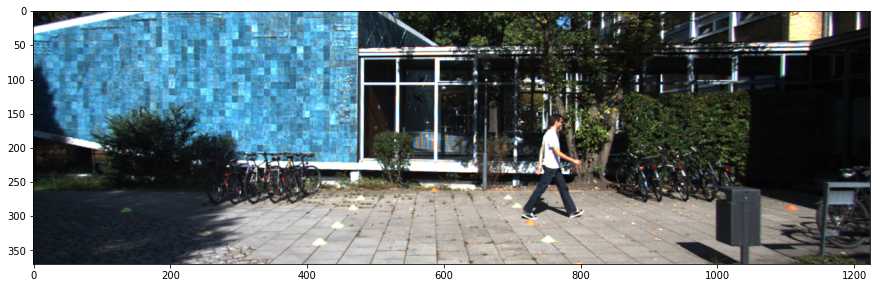

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti/training/image_2/000000.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [ ]:
# Check the label of a single image
!cat kitti/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.png'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.png', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [ ]:
from mmcv import Config
cfg = Config.fromfile('/content/mmdetection/configs/cascade_rcnn/cascade_rcnn_x101_64x4d_fpn_20e_coco.py')

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head[0].num_classes = 3
cfg.model.roi_head.bbox_head[1].num_classes = 3
cfg.model.roi_head.bbox_head[2].num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.lr_config.policy = "Step"
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# cfg.custom_hooks = cfg.custom_hooks[0]

# We can initialize the logger for training and have a look
# at the final config used for training
cfg.runner.max_epochs = 6
print(f'Config:\n{cfg.pretty_text}')
# print(cfg.custom_hooks[0])

Config:
model = dict(
    type='CascadeRCNN',
    backbone=dict(
        type='ResNeXt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://resnext101_64x4d'),
        groups=64,
        base_width=4),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dic

/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


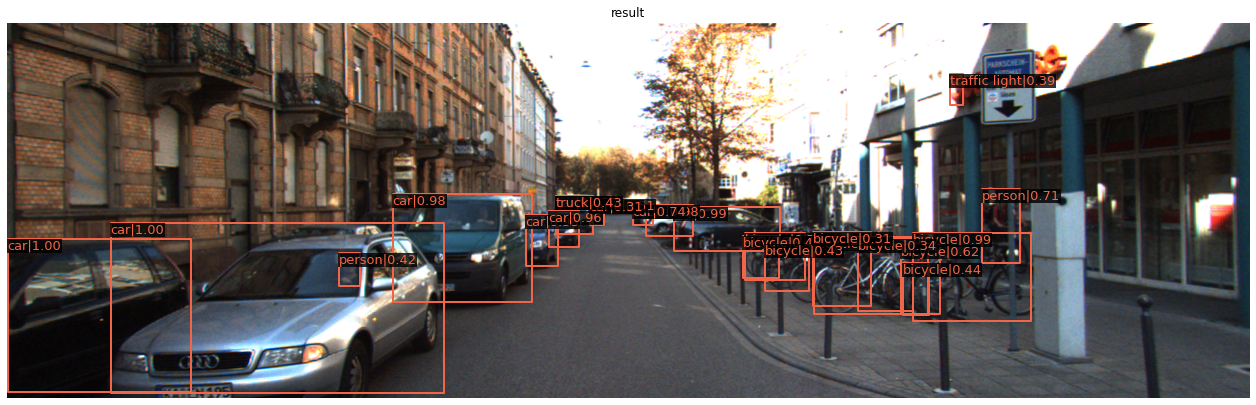

In [ ]:
img = mmcv.imread('kitti/training/image_2/000068.png')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155236 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
pwd

'/'

In [ ]:
cd /content/mmdetection

/content/mmdetection


In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection/mmdet/datasets/custom.py:178: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2022-01-21 12:58:47,058 - mmdet - INFO - load checkpoint from local path: checkpoints/cascade_rcnn_x101_64x4d_fpn_20e_coco_20200509_224357-051557b1.pth
2022-01-21 12:58:49,196 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.0.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.0.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.1.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.1.fc_cls.bias: copyi

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 3769/3769, 1.2 task/s, elapsed: 3090s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-01-21 15:29:27,482 - mmdet - INFO - 
+------------+-------+-------+--------+-------+
| class      | gts   | dets  | recall | ap    |
+------------+-------+-------+--------+-------+
| Car        | 14385 | 38216 | 0.962  | 0.909 |
| Pedestrian | 2280  | 7299  | 0.796  | 0.675 |
| Cyclist    | 893   | 3171  | 0.767  | 0.574 |
+------------+-------+-------+--------+-------+
| mAP        |       |       |        | 0.719 |
+------------+-------+-------+--------+-------+
2022-01-21 15:29:27,497 - mmdet - INFO - Epoch(val) [1][3769]	AP50: 0.7190, mAP: 0.7193
2022-01-21 15:30:01,915 - mmdet - INFO - Epoch [2][10/1856]	lr: 2.500e-03, eta: 8:12:57, time: 3.436, data_time: 0.231, memory: 6089, loss_rpn_cls: 0.0064, loss_rpn_bbox: 0.0081, s0.loss_cls: 0.0757, s0.acc: 97.1777, s0.loss_bbox: 0.0530, s1.loss_cls: 0.0281, s1.acc: 97.7191, s1.loss_bbox: 0.0727, s2.loss_cls: 0.0142, s2.acc: 97.9656, s2.loss_bbox: 0.0599, loss: 0.3180
2022-01-21 15:30:34,027 - mmdet - INFO - Epoch [2][20/1856]	lr: 2.

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 3769/3769, 1.2 task/s, elapsed: 3111s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-01-21 18:00:20,504 - mmdet - INFO - 
+------------+-------+-------+--------+-------+
| class      | gts   | dets  | recall | ap    |
+------------+-------+-------+--------+-------+
| Car        | 14385 | 26851 | 0.953  | 0.906 |
| Pedestrian | 2280  | 4460  | 0.761  | 0.663 |
| Cyclist    | 893   | 1830  | 0.684  | 0.576 |
+------------+-------+-------+--------+-------+
| mAP        |       |       |        | 0.715 |
+------------+-------+-------+--------+-------+
2022-01-21 18:00:20,522 - mmdet - INFO - Epoch(val) [2][3769]	AP50: 0.7150, mAP: 0.7149
2022-01-21 18:00:55,001 - mmdet - INFO - Epoch [3][10/1856]	lr: 2.500e-03, eta: 6:33:58, time: 3.443, data_time: 0.235, memory: 6089, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0049, s0.loss_cls: 0.0546, s0.acc: 97.8125, s0.loss_bbox: 0.0475, s1.loss_cls: 0.0185, s1.acc: 98.6609, s1.loss_bbox: 0.0696, s2.loss_cls: 0.0097, s2.acc: 98.6906, s2.loss_bbox: 0.0593, loss: 0.2664
2022-01-21 18:01:27,067 - mmdet - INFO - Epoch [3][20/1856]	lr: 2.

In [ ]:
# [>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3769/3769, 4.7 task/s, elapsed: 806s, ETA:     0s
# ---------------iou_thr: 0.5---------------
# 2022-01-15 13:46:47,912 - mmdet - INFO - 
# +------------+-------+-------+--------+-------+
# | class      | gts   | dets  | recall | ap    |
# +------------+-------+-------+--------+-------+
# | Car        | 14385 | 37318 | 0.963  | 0.909 |
# | Pedestrian | 2280  | 7584  | 0.797  | 0.679 |
# | Cyclist    | 893   | 3462  | 0.787  | 0.555 |
# +------------+-------+-------+--------+-------+
# | mAP        |       |       |        | 0.714 |
# +------------+-------+-------+--------+-------+
# 2022-01-15 13:46:47,922 - mmdet - INFO - Epoch(val) [1][3769]	AP50: 0.7140, mAP: 0.7144
# [>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3769/3769, 4.6 task/s, elapsed: 813s, ETA:     0s
# ---------------iou_thr: 0.5---------------
# 2022-01-15 14:52:44,724 - mmdet - INFO - 
# +------------+-------+-------+--------+-------+
# | class      | gts   | dets  | recall | ap    |
# +------------+-------+-------+--------+-------+
# | Car        | 14385 | 26124 | 0.948  | 0.903 |
# | Pedestrian | 2280  | 4037  | 0.742  | 0.657 |
# | Cyclist    | 893   | 1757  | 0.679  | 0.553 |
# +------------+-------+-------+--------+-------+
# | mAP        |       |       |        | 0.704 |
# +------------+-------+-------+--------+-------+
# 2022-01-15 14:52:44,732 - mmdet - INFO - Epoch(val) [2][3769]	AP50: 0.7040, mAP: 0.7044

In [ ]:
# [>>>>>>>>>>>>>>>>>>>>>>>>>>] 3769/3769, 1.2 task/s, elapsed: 3090s, ETA:     0s
# ---------------iou_thr: 0.5---------------
# 2022-01-21 15:29:27,482 - mmdet - INFO - 
# +------------+-------+-------+--------+-------+
# | class      | gts   | dets  | recall | ap    |
# +------------+-------+-------+--------+-------+
# | Car        | 14385 | 38216 | 0.962  | 0.909 |
# | Pedestrian | 2280  | 7299  | 0.796  | 0.675 |
# | Cyclist    | 893   | 3171  | 0.767  | 0.574 |
# +------------+-------+-------+--------+-------+
# | mAP        |       |       |        | 0.719 |
# +------------+-------+-------+--------+-------+
# 2022-01-21 15:29:27,497 - mmdet - INFO - Epoch(val) [1][3769]	AP50: 0.7190, mAP: 0.7193
# [>>>>>>>>>>>>>>>>>>>>>>>>>>] 3769/3769, 1.2 task/s, elapsed: 3111s, ETA:     0s
# ---------------iou_thr: 0.5---------------
# 2022-01-21 18:00:20,504 - mmdet - INFO - 
# +------------+-------+-------+--------+-------+
# | class      | gts   | dets  | recall | ap    |
# +------------+-------+-------+--------+-------+
# | Car        | 14385 | 26851 | 0.953  | 0.906 |
# | Pedestrian | 2280  | 4460  | 0.761  | 0.663 |
# | Cyclist    | 893   | 1830  | 0.684  | 0.576 |
# +------------+-------+-------+--------+-------+
# | mAP        |       |       |        | 0.715 |
# +------------+-------+-------+--------+-------+

In [ ]:
img = mmcv.imread('kitti/training/image_2/000068.png')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


In [ ]:
# torch.save(model.state_dict(), "/content/")

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

In [ ]:
%cp /content/mmdetection/tutorial_exps/epoch_3.pth /content/drive/MyDrive/Masters/SDC/Project/

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

/content/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/content/mmdetection/mmdet/apis/inference.py:205: UserWarning: "block" will be deprecated in v2.9.0,Please use "wait_time"
  warnings.warn('"block" will be deprecated in v2.9.0,'
/content/mmdetection/mmdet/apis/inference.py:207: UserWarning: "fig_size" are deprecated and takes no effect.
  warnings.warn('"fig_size" are deprecated and takes no effect.')
/content/mmdetection/mmdet/core/visualization/image.py:75: UserWarning: "font_scale" will be deprecated in v2.9.0,Please use "font_size"
  warnings.warn('"font_scale" will be deprecated in v2.9.0,'


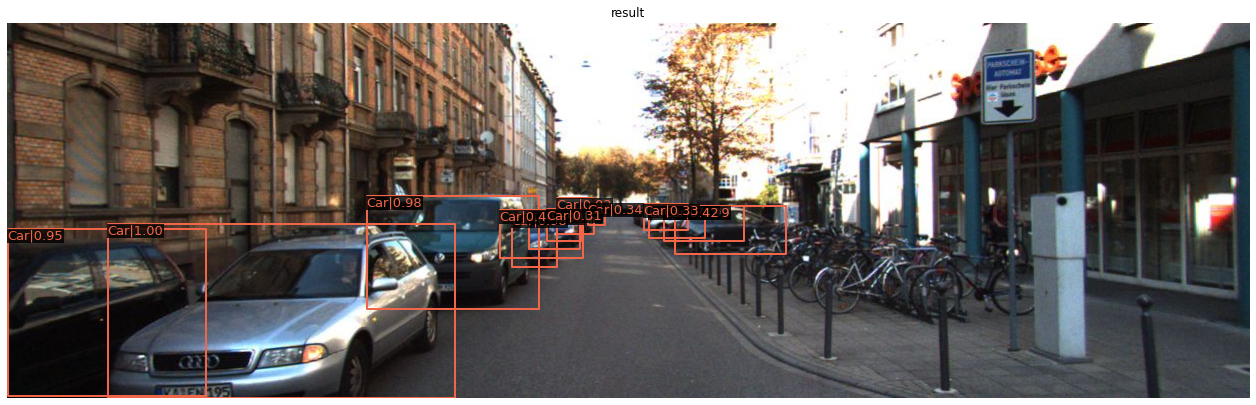

In [ ]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


## New section

In [ ]:
%cd /content

/content


In [ ]:
!mkdir kitti
%cd kitti
# !mkdir training
# %cd training

/content/kitti


In [ ]:
pwd

'/content/mmdetection/kitti'

In [ ]:
# download, decompress the data
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
!unzip data_object_image_2.zip
%rm data_object_image_2.zip
!wget  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
!unzip data_object_label_2.zip
%rm data_object_label_2.zip
# !unzip kitti_tiny.zip > /dev/null

Streaming output truncated to the last 5000 lines.
 extracting: training/label_2/001705.txt  
 extracting: training/label_2/000367.txt  
 extracting: training/label_2/006048.txt  
 extracting: training/label_2/005468.txt  
 extracting: training/label_2/007308.txt  
 extracting: training/label_2/001417.txt  
 extracting: training/label_2/006638.txt  
 extracting: training/label_2/002132.txt  
 extracting: training/label_2/002407.txt  
 extracting: training/label_2/007186.txt  
 extracting: training/label_2/004363.txt  
 extracting: training/label_2/005764.txt  
 extracting: training/label_2/003298.txt  
 extracting: training/label_2/002664.txt  
 extracting: training/label_2/002322.txt  
 extracting: training/label_2/005098.txt  
 extracting: training/label_2/007135.txt  
 extracting: training/label_2/001415.txt  
 extracting: training/label_2/000344.txt  
 extracting: training/label_2/005904.txt  
 extracting: training/label_2/007166.txt  
 extracting: training/label_2/000502.txt  
 ex

In [ ]:
%cd ..
!ls

/content
drive  kitti  sample_data


In [ ]:
!tree kitti

Streaming output truncated to the last 5000 lines.
│       ├── 002485.txt
│       ├── 002486.txt
│       ├── 002487.txt
│       ├── 002488.txt
│       ├── 002489.txt
│       ├── 002490.txt
│       ├── 002491.txt
│       ├── 002492.txt
│       ├── 002493.txt
│       ├── 002494.txt
│       ├── 002495.txt
│       ├── 002496.txt
│       ├── 002497.txt
│       ├── 002498.txt
│       ├── 002499.txt
│       ├── 002500.txt
│       ├── 002501.txt
│       ├── 002502.txt
│       ├── 002503.txt
│       ├── 002504.txt
│       ├── 002505.txt
│       ├── 002506.txt
│       ├── 002507.txt
│       ├── 002508.txt
│       ├── 002509.txt
│       ├── 002510.txt
│       ├── 002511.txt
│       ├── 002512.txt
│       ├── 002513.txt
│       ├── 002514.txt
│       ├── 002515.txt
│       ├── 002516.txt
│       ├── 002517.txt
│       ├── 002518.txt
│       ├── 002519.txt
│       ├── 002520.txt
│       ├── 002521.txt
│       ├── 002522.txt
│       ├── 002523.txt
│       ├── 002524.txt
│       ├── 002525.txt
│     

In [ ]:
%cd /content/drive/MyDrive/Masters/SDC/Project/mmdetection

/content/drive/MyDrive/Masters/SDC/Project/mmdetection


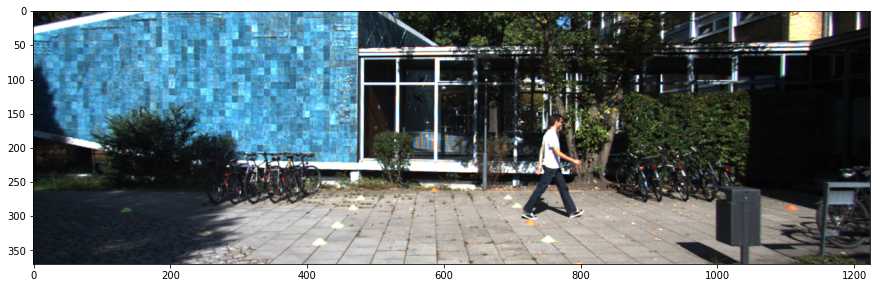

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/kitti/training/image_2/000000.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [ ]:
# Check the label of a single image
!cat kitti/training/label_2/000000.txt

cat: kitti/training/label_2/000000.txt: No such file or directory


In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.png'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.png', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

KeyError: ignored

In [ ]:
from mmcv import Config
cfg = Config.fromfile('/content/drive/MyDrive/Masters/SDC/Project/mmdetection/configs/cascade_rcnn/cascade_rcnn_x101_64x4d_fpn_20e_coco.py')

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = '/content/kitti/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = '/content/kitti/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = '/content/kitti/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = '/content/kitti/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head[0].num_classes = 3
cfg.model.roi_head.bbox_head[1].num_classes = 3
cfg.model.roi_head.bbox_head[2].num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/content/drive/MyDrive/Masters/SDC/Project/Models/epoch_2.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.lr_config.policy = "Step"
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 2
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# cfg.custom_hooks = cfg.custom_hooks[0]

# We can initialize the logger for training and have a look
# at the final config used for training
cfg.runner.max_epochs = 2
print(f'Config:\n{cfg.pretty_text}')
# print(cfg.custom_hooks[0])

Config:
model = dict(
    type='CascadeRCNN',
    backbone=dict(
        type='ResNeXt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(
            type='Pretrained', checkpoint='open-mmlab://resnext101_64x4d'),
        groups=64,
        base_width=4),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dic

/content/drive/MyDrive/Masters/SDC/Project/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


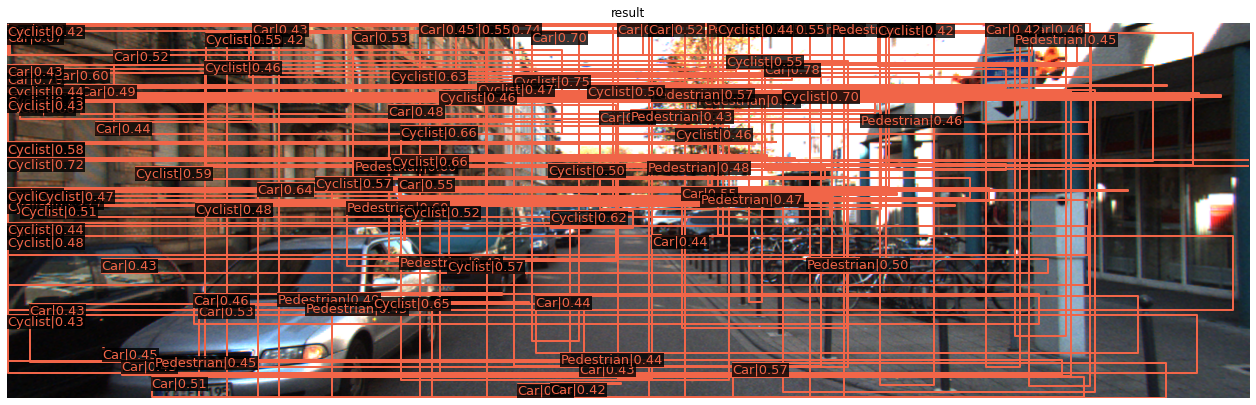

In [ ]:
img = mmcv.imread('/content/kitti/training/image_2/000068.png')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/drive/MyDrive/Masters/SDC/Project/mmdetection/mmdet/datasets/custom.py:178: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2022-02-05 12:37:01,681 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/Masters/SDC/Project/Models/epoch_2.pth
2022-02-05 12:37:18,262 - mmdet - INFO - Start running, host: root@02da72d4a7c4, work_dir: /content/drive/MyDrive/Masters/SDC/Project/mmdetection/tutorial_exps
2022-02-05 12:37:18,265 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook        

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 3769/3769, 1.2 task/s, elapsed: 3256s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-05 16:56:27,541 - mmdet - INFO - 
+------------+-------+-------+--------+-------+
| class      | gts   | dets  | recall | ap    |
+------------+-------+-------+--------+-------+
| Car        | 14385 | 21304 | 0.927  | 0.890 |
| Pedestrian | 2280  | 4054  | 0.750  | 0.661 |
| Cyclist    | 893   | 1170  | 0.594  | 0.525 |
+------------+-------+-------+--------+-------+
| mAP        |       |       |        | 0.692 |
+------------+-------+-------+--------+-------+
2022-02-05 16:56:27,553 - mmdet - INFO - Epoch(val) [2][3769]	AP50: 0.6920, mAP: 0.6917


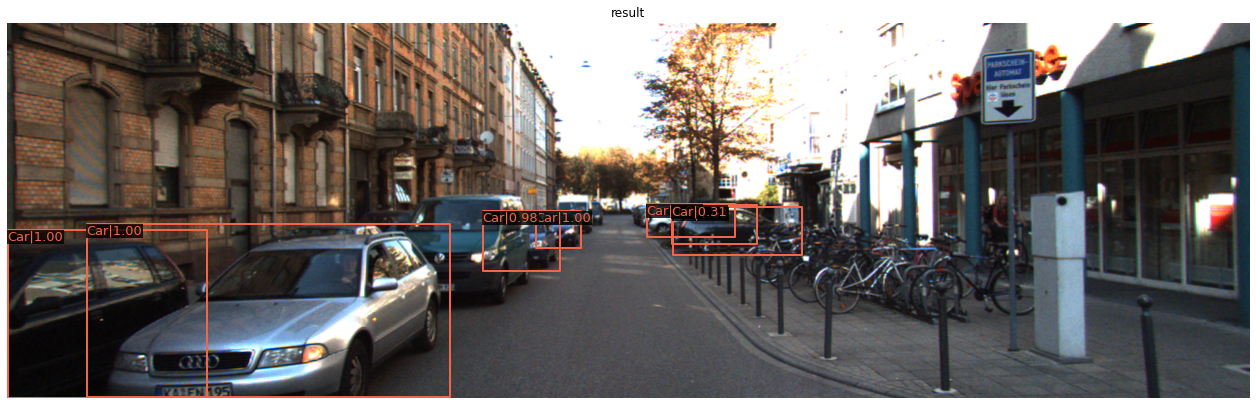

In [ ]:
img = mmcv.imread('/content/kitti/training/image_2/000068.png')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


## Orignal

In [ ]:
# download, decompress the data
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2021-02-20 03:04:04--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  8.44MB/s    in 0.8s    

2021-02-20 03:04:06 (8.44 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [ ]:
# Check the directory structure of the tiny data
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (165 kB/s)
Selecting previously unselected package tree.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg
│   │   ├── 000005.jpeg
│   │   ├── 000006.jpeg
│   │   ├── 000007.jpeg
│   │   ├── 000008.jpeg
│   │   ├── 000009.jpeg
│   │   ├── 00

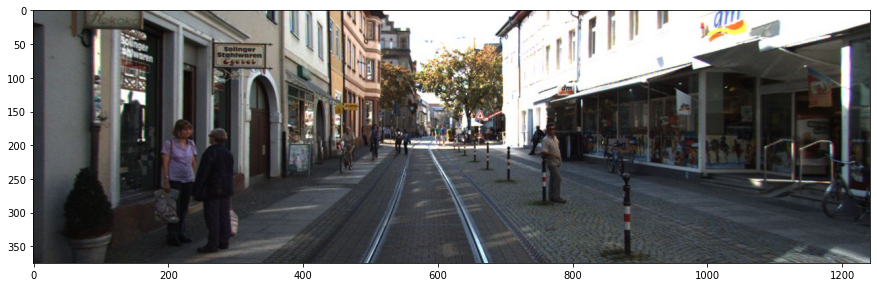

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the kitti annotation format into the middle format. In this tutorial we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a look at the annotation txt file.



In [ ]:
# Check the label of a single image
!cat kitti_tiny/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicates the bboxes. We need to read annotations of each image and convert them into middle format MMDetection accept is as below:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray> (n, 4),
            'labels': <np.ndarray> (n, ),
            'bboxes_ignore': <np.ndarray> (k, 4), (optional field)
            'labels_ignore': <np.ndarray> (k, 4) (optional field)
        }
    },
    ...
]
```

In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection/mmdet/datasets/custom.py:155: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2021-02-20 03:04:44,198 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_msra-5891d200.pth" to /root/.cache/torch/checkpoints/resnet50_msra-5891d200.pth


2021-02-20 03:04:57,872 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias



2021-02-20 03:04:58,180 - mmdet - INFO - load checkpoint from checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2021-02-20 03:04:58,313 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([12]).
unexpected key in source state_dict: roi_head.mask_head.conv

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 11.4 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-02-20 03:07:08,400 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 131  | 0.968  | 0.879 |
| Pedestrian | 13  | 58   | 0.846  | 0.747 |
| Cyclist    | 7   | 67   | 0.429  | 0.037 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.555 |
+------------+-----+------+--------+-------+
2021-02-20 03:07:08,403 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5550, mAP: 0.5545


### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!